# Imports and Functions

In [1]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [2]:
from sunlab.svm import *

In [3]:
import seaborn as sns

# Setup

In [4]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [5]:
training_data = process_and_load_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'])

In [6]:
dataset = model.scaler.scaler.inverse_transform(model.autoencoder(training_data.dataset).numpy())

pixel2dist = 1.075268

svm_scaler, svm_clf = svm_load(FILES["SVM"]["ONNX"]["SCALER"], FILES["SVM"]["ONNX"]["MODEL"])

classification = svm_infer(dataset, pixel2dist=pixel2dist, scaler_model=svm_scaler, clf_model=svm_clf)
classification.shape

(19479, 4)

In [7]:
tclassification = np.hstack([classification,~(classification>0.7).any(-1).reshape((-1,1))])
s_c = np.argmax(classification, -1)
s_tc = np.argmax(tclassification, -1)

In [8]:
training_classification = training_data.dataframe[['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']].to_numpy()
training_tclassification = np.hstack([training_classification,~(training_classification>0.7).any(-1).reshape((-1,1))])
tr_c = np.argmax(training_classification, -1)
tr_tc = np.argmax(training_tclassification, -1)

<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

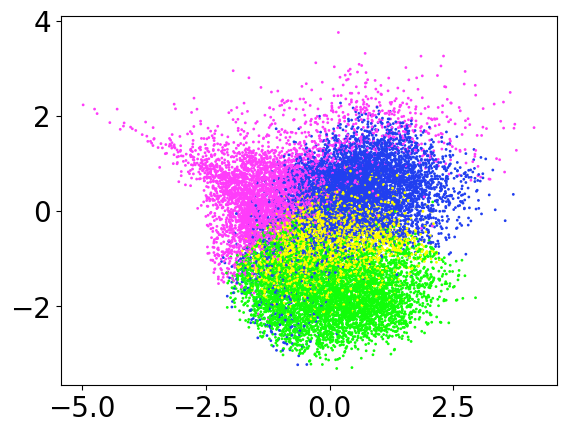

In [9]:
plt.scatter2d(model.encoder(training_data.dataset).numpy(), c=tr_c, cmap=Pmap, s=1)

<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

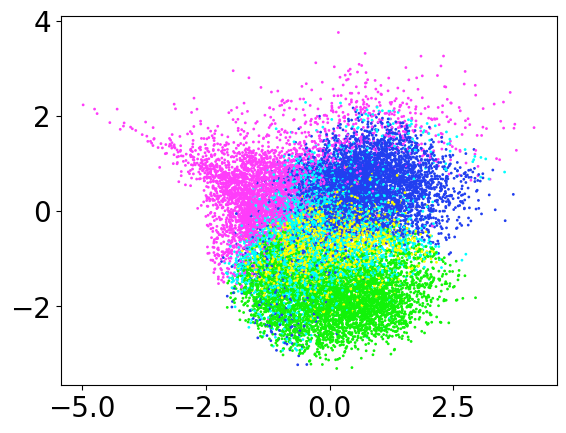

In [10]:
plt.scatter2d(model.encoder(training_data.dataset).numpy(), c=tr_tc, cmap=Pmapx, s=1)

<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

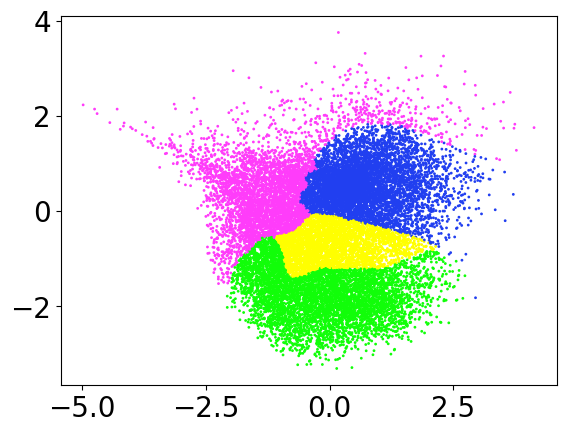

In [11]:
plt.scatter2d(model.encoder(training_data.dataset).numpy(), c=s_c, cmap=Pmap, s=1)

<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

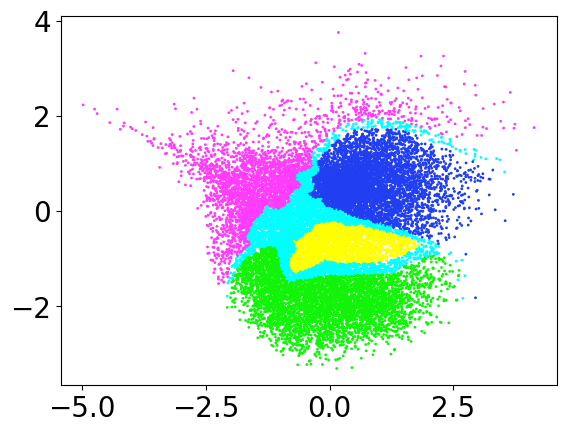

In [12]:
plt.scatter2d(model.encoder(training_data.dataset).numpy(), c=s_tc, cmap=Pmapx, s=1)

In [46]:
# Exclude transitional phenotypes and the transitional phenotype region
_filter = ~(tr_tc==4)

In [47]:
misplaced = 1-np.sum(np.argmax(classification, -1)[_filter] == training_data.labels[_filter])/training_data.labels[_filter].shape[0]
f"{misplaced*100:.1f}%",training_data.labels[_filter].shape

('17.8%', (15834,))

In [48]:
accuracy = 1-misplaced
f"{accuracy*100:.1f}%",training_data.labels[_filter].shape

('82.2%', (15834,))

In [49]:
_filter = tr_tc > -1
misplaced = 1-np.sum(np.argmax(classification, -1)[_filter] == training_data.labels[_filter])/training_data.labels[_filter].shape[0]
f"{misplaced*100:.1f}%",training_data.labels[_filter].shape

('24.8%', (19479,))

In [50]:
accuracy = 1-misplaced
f"{accuracy*100:.1f}%",training_data.labels[_filter].shape

('75.2%', (19479,))

In [71]:
phenotype_names = ['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']

In [88]:
_first_filter = ~(tr_tc==4)
for phenotype in range(4):
    _phenotype_filter = tr_c == phenotype
    _filter = _first_filter & _phenotype_filter
    accuracy = np.sum(np.argmax(classification, -1)[_filter] == training_data.labels[_filter])/training_data.labels[_filter].shape[0]
    print(f"{phenotype}:{phenotype_names[phenotype]:12}, {accuracy*100:.1f}%   {_filter.sum()}")
_first_filter.sum()

0:ActinEdge   , 60.1%   2020
1:Filopodia   , 86.9%   3725
2:Bleb        , 88.2%   4712
3:Lamellipodia, 81.8%   5377


15834

In [89]:
_first_filter = tr_tc > -1
for phenotype in range(4):
    _phenotype_filter = tr_c == phenotype
    _filter = _first_filter & _phenotype_filter
    accuracy = np.sum(np.argmax(classification, -1)[_filter] == training_data.labels[_filter])/training_data.labels[_filter].shape[0]
    print(f"{phenotype}:{phenotype_names[phenotype]:12}, {accuracy*100:.1f}%   {_filter.sum()}")
_first_filter.sum()

0:ActinEdge   , 56.3%   2928
1:Filopodia   , 82.9%   4318
2:Bleb        , 80.9%   5715
3:Lamellipodia, 73.6%   6518


19479